# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [65]:
! git clone https://github.com/ds4e/linearModels

fatal: destination path 'linearModels' already exists and is not an empty directory.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.regressionplots import plot_partregress

In [67]:
airbnb = pd.read_csv('linearModels/data/airbnb_hw.csv')
airbnb.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [68]:
#Clean Price column
airbnb['Price'] = airbnb['Price'].str.replace('$', '').str.replace(',', '').astype(float)
airbnb['Price'].head()

,Price
0,145.0
1,37.0
2,28.0
3,199.0
4,549.0


In [69]:
#Convert Host Sine to datetime and fill in missing values
airbnb['Host Since'] = pd.to_datetime(airbnb['Host Since'], errors='coerce')
airbnb['Host Since'].fillna("Unknown", inplace=True)
airbnb['Host Since'].head()

<ipython-input-69-3040d5fb92c6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  airbnb['Host Since'].fillna("Unknown", inplace=True)
<ipython-input-69-3040d5fb92c6>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  airbnb['Host Since'].fillna("Unknown", inplace=True)


,Host Since
0,Unknown
1,Unknown
2,Unknown
3,2008-06-26 00:00:00
4,2008-06-26 00:00:00


In [70]:
#Dropping missing values
print(airbnb.isnull().sum())
airbnb.dropna(inplace=True)

Host Id                          0
Host Since                       0
Name                             0
Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8323
Room Type                        0
Zipcode                        134
Beds                            85
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating          8323
dtype: int64


In [71]:
#Ensuring missing values were dropped
print(airbnb.isnull().sum())

Host Id                       0
Host Since                    0
Name                          0
Neighbourhood                 0
Property Type                 0
Review Scores Rating (bin)    0
Room Type                     0
Zipcode                       0
Beds                          0
Number of Records             0
Number Of Reviews             0
Price                         0
Review Scores Rating          0
dtype: int64


In [72]:
#Checking distribution of price values
airbnb['Price'].describe()

,Price
count,22010.000000
mean,154.762699
std,148.993525
min,10.000000
25%,85.000000
50%,125.000000
75%,190.000000
max,10000.000000


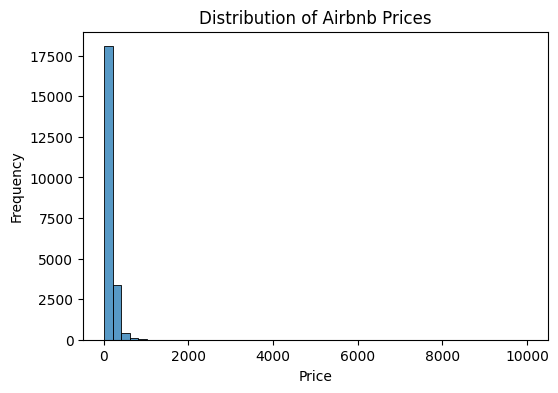

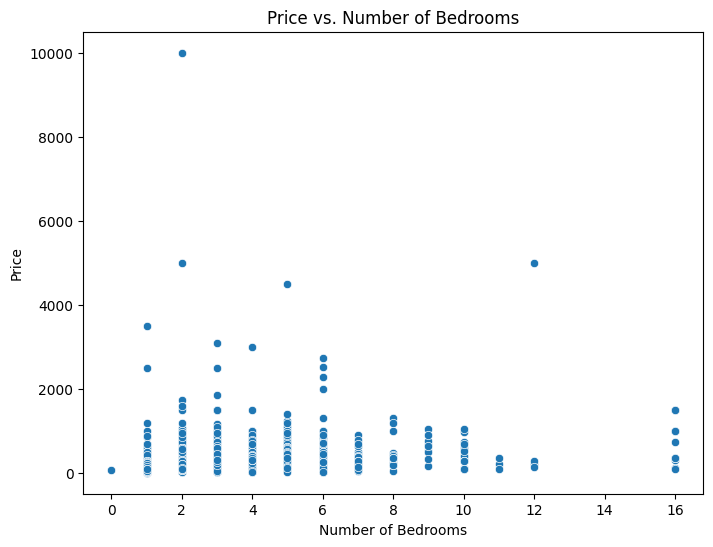

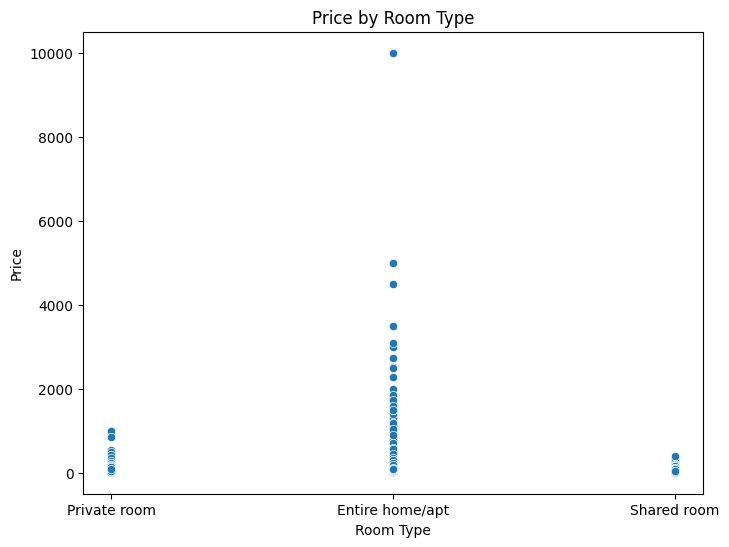

In [73]:
#Visualizations
#Histogram of Price
plt.figure(figsize=(6, 4))
sns.histplot(airbnb['Price'], bins=50)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
#The graph looks like this because there is one large outlier

#Scatterplot of Price to Number of Bedrooms
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Beds', y='Price', data=airbnb)
plt.title('Price vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()

#Room Type and Price Relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Room Type', y='Price', data=airbnb)
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()
#This graph also looks condensed because of the one Price outlier

In [74]:
#Variable Transformation for Regression Analysis
#Convert categorical to dummy
airbnb = pd.get_dummies(airbnb, columns=['Room Type'], drop_first=True)
airbnb['Price_log'] = np.log(airbnb['Price']) #to handle outlier
airbnb.head()


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Room Type_Private room,Room Type_Shared room,Price_log
4,500,2008-06-26 00:00:00,Trendy Times Square Loft,Manhattan,Apartment,95.0,10036.0,3.0,1,39,549.0,96.0,True,False,6.308098
5,1039,2008-07-25 00:00:00,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,100.0,11222.0,1.0,1,4,149.0,100.0,False,False,5.003946
6,1783,2008-08-12 00:00:00,Amazing Also,Manhattan,Apartment,100.0,10004.0,1.0,1,9,250.0,100.0,False,False,5.521461
7,2078,2008-08-15 00:00:00,"Colorful, quiet, & near the subway!",Brooklyn,Apartment,90.0,11201.0,1.0,1,80,90.0,94.0,True,False,4.499810
8,2339,2008-08-20 00:00:00,East Village Cocoon: 2 Bedroom Flat,Manhattan,Apartment,90.0,10009.0,2.0,1,95,270.0,90.0,False,False,5.598422


In [75]:
airbnb.columns = airbnb.columns.str.replace(' ', '_')  # Replace spaces with underscores
airbnb.columns = airbnb.columns.str.strip()  # Remove leading/trailing spaces
airbnb.columns = airbnb.columns.str.lower()  # Convert to lowercase

print(airbnb.columns)

Index(['host_id', 'host_since', 'name', 'neighbourhood_', 'property_type',
       'review_scores_rating_(bin)', 'zipcode', 'beds', 'number_of_records',
       'number_of_reviews', 'price', 'review_scores_rating',
       'room_type_private_room', 'room_type_shared_room', 'price_log'],
      dtype='object')


In [78]:
#Train-Test Split
X = airbnb.drop(['price', 'price_log'], axis=1)
y = airbnb['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
#Basic Linear Models
#Model 1: using only number of beds (Beds)
X_train_model_1 = X_train[['beds']]
X_test_model_1 = X_test[['beds']]

model_1 = sm.OLS(y_train, sm.add_constant(X_train_model_1)).fit()

y_train_predict_model_1 = model_1.predict(sm.add_constant(X_train_model_1))
y_test_predict_model_1 = model_1.predict(sm.add_constant(X_test_model_1))

rmse_train_model_1 = np.sqrt(mean_squared_error(y_train, y_train_predict_model_1))
rmse_test_model_1 = np.sqrt(mean_squared_error(y_test, y_test_predict_model_1))

r2_train_model_1 = model_1.rsquared
r2_test_model_1 = model_1.rsquared_adj

print("Model 1 (beds):")
print(f"Training RMSE: {rmse_train_model_1:.2f}")
print(f"Test RMSE: {rmse_test_model_1:.2f}")
print(f"Training R-squared: {r2_train_model_1:.2f}")
print(f"Test R-squared: {r2_test_model_1:.2f}")
print("\n")


Model 1 (beds):
Training RMSE: 141.67
Test RMSE: 125.35
Training R-squared: 0.13
Test R-squared: 0.13




In [82]:
#Model 2
X_train_model_2 = X_train[['beds', 'room_type_private_room']].astype(float) # Convert to numeric
X_test_model_2 = X_test[['beds', 'room_type_private_room']].astype(float) # Convert to numeric

# Define the model
model_2 = sm.OLS(y_train, sm.add_constant(X_train_model_2))

#Fit the model with the initial features
results_model_2 = model_2.fit()

# Predict on training and testing data using original features
y_train_predict_model_2 = results_model_2.predict(sm.add_constant(X_train_model_2))
y_test_predict_model_2 = results_model_2.predict(sm.add_constant(X_test_model_2))

# Calculate metrics for Model 2 using original features
rmse_train_model_2 = np.sqrt(mean_squared_error(y_train, y_train_predict_model_2))
rmse_test_model_2 = np.sqrt(mean_squared_error(y_test, y_test_predict_model_2))

r2_train_model_2 = results_model_2.rsquared
r2_test_model_2 = results_model_2.rsquared_adj

print("Model 2 (beds, room_type_private room):")
print(f"Training RMSE: {rmse_train_model_2:.2f}")
print(f"Test RMSE: {rmse_test_model_2:.2f}")
print(f"Training R-squared: {r2_train_model_2:.2f}")
print(f"Test R-squared: {r2_test_model_2:.2f}")
print("\n")

Model 2 (beds, room_type_private room):
Training RMSE: 136.19
Test RMSE: 119.93
Training R-squared: 0.19
Test R-squared: 0.19




Model 2 has a larger R-squared/an R-squared closer to 1. Therefore, it is the better model.

<Figure size 800x600 with 0 Axes>

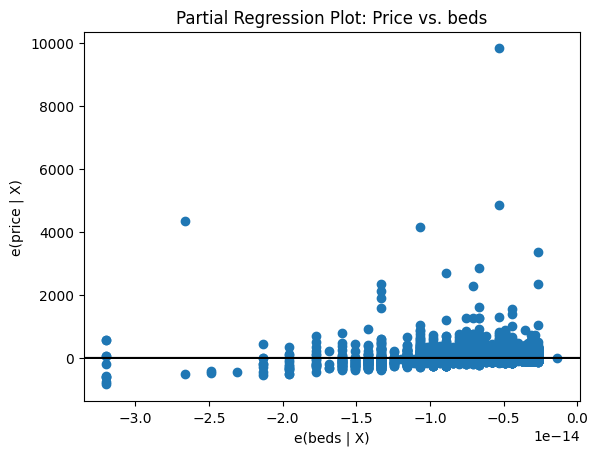

<Figure size 800x600 with 0 Axes>

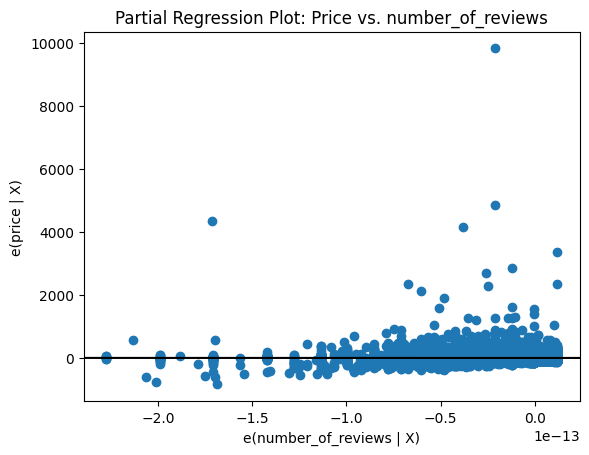

<Figure size 800x600 with 0 Axes>

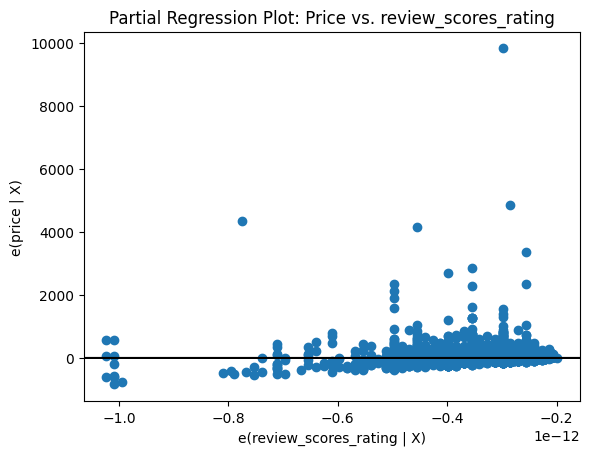

In [83]:
#Make partial correlation plots for each of the numeric variables in your model.

for col in ['beds', 'number_of_reviews', 'review_scores_rating']:
    fig = plt.figure(figsize=(8, 6))
    plot_partregress(endog='price', exog_i=col, exog_others=['beds', 'number_of_reviews', 'review_scores_rating'], data=airbnb, obs_labels=False)
    plt.title(f'Partial Regression Plot: Price vs. {col}')
    plt.show()

#The largest significant non-linearity that I am noticing is with Price and Review Scores Rating. The data appears the least correlated.

In [89]:
#Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value.

# Interaction between 'beds' and 'review_scores_rating'
X_train['beds_x_rating'] = X_train['beds'] * X_train['review_scores_rating']
X_test['beds_x_rating'] = X_test['beds'] * X_test['review_scores_rating']

# Transformation of 'number_of_reviews'
X_train['log_reviews'] = np.log1p(X_train['number_of_reviews'])  # Use log1p to handle zero values
X_test['log_reviews'] = np.log1p(X_test['number_of_reviews'])


# Build the complex model
X_train_complex = X_train[['beds', 'room_type_private_room', 'beds_x_rating', 'log_reviews']]
X_test_complex = X_test[['beds', 'room_type_private_room', 'beds_x_rating', 'log_reviews']]

X_train_complex = X_train_complex.astype(float) # Convert all columns to numeric
X_test_complex = X_test_complex.astype(float)

model_complex = sm.OLS(y_train, sm.add_constant(X_train_complex)).fit()

y_train_predict_complex = model_complex.predict(sm.add_constant(X_train_complex))
y_test_predict_complex = model_complex.predict(sm.add_constant(X_test_complex))

rmse_train_complex = np.sqrt(mean_squared_error(y_train, y_train_predict_complex))
rmse_test_complex = np.sqrt(mean_squared_error(y_test, y_test_predict_complex))

r2_train_complex = model_complex.rsquared
r2_test_complex = model_complex.rsquared_adj

print("Complex Model:")
print(f"Training RMSE: {rmse_train_complex:.2f}")
print(f"Test RMSE: {rmse_test_complex:.2f}")
print(f"Training R-squared: {r2_train_complex:.2f}")
print(f"Test R-squared: {r2_test_complex:.2f}")
print("\n")


print("Comparison with simpler models:")


#Compare with model_2
print("Model 2 (Beds, Room Type_Private room):")
print(f"Training RMSE: {rmse_train_model_2:.2f}")
print(f"Test RMSE: {rmse_test_model_2:.2f}")
print(f"Training R-squared: {r2_train_model_2:.2f}")
print(f"Test R-squared: {r2_test_model_2:.2f}")

#How does the more complex model your build compare to the simpler ones?
#The R^2 is better in the complex model because it is even closer to one than the simpler models. The Test RMSE is also higher which also is a sign its a better model.

Complex Model:
Training RMSE: 135.60
Test RMSE: 122.46
Training R-squared: 0.20
Test R-squared: 0.20


Comparison with simpler models:
Model 2 (Beds, Room Type_Private room):
Training RMSE: 136.19
Test RMSE: 119.93
Training R-squared: 0.19
Test R-squared: 0.19


In [91]:
print("\nSummary:")
print("Model 1 (Basic): Simple model with bedrooms, accommodates, and beds.")
print(f"  RMSE Train: {rmse_train_model_1}, RMSE Test: {rmse_test_model_1}, R2 Train: {r2_train_model_1}, R2 Test: {r2_test_model_1}")
print("Model 2 (Basic + Room Type): Model 1 with room type included.")
print(f"  RMSE Train: {rmse_train_model_2}, RMSE Test: {rmse_test_model_2}, R2 Train: {r2_train_model_2}, R2 Test: {r2_test_model_2}")
print("Model 3 (Complex): Model with transformations and interactions.")
print(f"  RMSE Train: {rmse_train_complex}, RMSE Test: {rmse_test_complex}, R2 Train: {r2_train_complex}, R2 Test: {r2_test_complex}")

#Summarizing all models here paints a clear picture of the different model specifics. The complex model has the best R2 value because it is the closest to 1. However, model 2's R2 is very close to the complex model R2. The Test RMSE is interesting to look at. You want a lower RMSE, but the complex model does not have the lowest RMSE, even though it has the best R2. Model 2 has the best RMSE, followed by the complex model.
#Have you learned anything about overfitting and underfitting, or model selection?: I have learned a lot about overfitting and underfitting with this lab. It is super important to use train, test to figure out overfitting and underfitting and analyzing the R2 and RMSE are the perfect ways to do that. Furthermore, I liked creating the different models to figure out the best one. Comparing them all together in this manner in a big summary model makes it especially easy to compare the numeric values of the train and test models to each other.


Summary:
Model 1 (Basic): Simple model with bedrooms, accommodates, and beds.
  RMSE Train: 141.6730632787835, RMSE Test: 125.34759995605808, R2 Train: 0.1256983026758478, R2 Test: 0.12564864337235326
Model 2 (Basic + Room Type): Model 1 with room type included.
  RMSE Train: 136.19235669190144, RMSE Test: 119.92517201509176, R2 Train: 0.19203560520984098, R2 Test: 0.19194381715022268
Model 3 (Complex): Model with transformations and interactions.
  RMSE Train: 135.60126166218976, RMSE Test: 122.45623026848729, R2 Train: 0.19903375631593723, R2 Test: 0.19885174955716112


In [96]:
#Use Lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Initialize and train Lasso model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_complex, y_train)

# Get coefficients and identify selected features
coefficients = lasso_model.coef_
selected_features = X_train_complex.columns[np.abs(coefficients) > 1e-4]

print("Selected Features by Lasso:", selected_features)


y_train_pred_lasso = lasso_model.predict(X_train_complex)
y_test_pred_lasso = lasso_model.predict(X_test_complex)

# Calculate RMSE and R-squared
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"\nLasso Model:")
print(f"Training RMSE: {rmse_train_lasso:.2f}")
print(f"Test RMSE: {rmse_test_lasso:.2f}")
print(f"Training R-squared: {r2_train_lasso:.2f}")
print(f"Test R-squared: {r2_test_lasso:.2f}")

#Which does it select? What are the RMSE and  𝑅2 ?
#The Lasso feature selects beds, room_type_private_room, beds_x_rating, and log_reviews.

Selected Features by Lasso: Index(['beds', 'room_type_private_room', 'beds_x_rating', 'log_reviews'], dtype='object')

Lasso Model:
Training RMSE: 135.60
Test RMSE: 122.29
Training R-squared: 0.20
Test R-squared: 0.22
